### 1. Imports

In [1]:
import os
import csv
import random
from pathlib import Path
from typing import Tuple, List

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline


### 2. Globals

In [2]:
ROOT_DIR     = Path('.')
CSV_PATH     = ROOT_DIR/'data/images/0_data.csv'
MASK_DIR     = ROOT_DIR/'data/masked'          # contains IMG_xxxx_mask.jpg
SEED         = 42
BATCH_SIZE   = 64
LR           = 1e-3
EPOCHS       = 150
VAL_SPLIT    = 0.30                            # 70 / 30
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'

# grid size: split each mask into WxH cells
GRID_W = 12
GRID_H = 8

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)


/home/leo/anaconda3/envs/silkworm/lib/python3.11/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### 3. Utils

In [3]:
# Colour codes on the active device (cuda or cpu)
WORM_RGB = torch.tensor([255,   0,   0], dtype=torch.uint8, device=DEVICE)   # red
LEAF_RGB = torch.tensor([  0, 255,   0], dtype=torch.uint8, device=DEVICE)   # green
BACK_RGB = torch.tensor([128, 128, 128], dtype=torch.uint8, device=DEVICE)   # gray

@torch.no_grad()
def class_ratios_grid(img: Image.Image) -> torch.Tensor:
    """
    Returns tensor [3, GRID_H, GRID_W]  (device) with per-cell class ratios.
    """
    arr = torch.from_numpy(np.asarray(img, dtype=np.uint8).copy()).to(DEVICE)  # H×W×3
    worms = torch.all(arr == WORM_RGB, dim=-1).float()
    leaves = torch.all(arr == LEAF_RGB, dim=-1).float()
    backs  = torch.all(arr == BACK_RGB, dim=-1).float()
    full   = torch.stack([worms, leaves, backs], 0)    # [3,H,W]

    # average-pool: each value becomes the fraction in that cell
    pooled = torch.nn.functional.avg_pool2d(
        full, 
        kernel_size=(worms.shape[0] // GRID_H, worms.shape[1] // GRID_W)
    ) * (GRID_H * GRID_W)                                # convert mean→ratio
    return pooled                                        # [3,Hg, Wg]

def show_weight_grid(matrix: np.ndarray, title: str, cmap="coolwarm"):
    """
    matrix : 2-D array (H×W)
    """
    H, W = matrix.shape
    plt.figure(figsize=(W * 0.8, H * 0.8))
    im = plt.imshow(matrix, cmap=cmap)
    plt.title(title)
    plt.xticks(range(W)); plt.yticks(range(H))
    # annotate every cell
    for i in range(H):
        for j in range(W):
            text = f"{matrix[i,j]:+.2f}"
            plt.text(j, i, text,
                     ha='center', va='center',
                     color='white' if abs(matrix[i,j]) > np.max(abs(matrix))/2 else 'black',
                     fontsize=8)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

### 4. Data

In [ ]:
class SilkwormFeedDataset(Dataset):
    """
    Each sample:  x  [3, GRID_H, GRID_W] ,  y  scalar (float 0/1)
    """
    def __init__(self, csv_file: Path, mask_dir: Path):
        df = pd.read_csv(csv_file, engine='python')
        feats, labels = [], []

        for _, row in df.iterrows():
            mask_path = mask_dir / f"{Path(row['foto']).stem}_mask.png"
            if not mask_path.exists():
                continue
            ratios_grid = class_ratios_grid(Image.open(mask_path))
            feats.append(ratios_grid)
            labels.append(float(row['classificazione']))

        self.x = torch.stack(feats).to(DEVICE)           # [N, 3, Hg, Wg]
        self.y = torch.tensor(labels, dtype=torch.float32, device=DEVICE).unsqueeze(1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]



# 1m22s to load dataset on 1660 Ti Mobile
full_ds = SilkwormFeedDataset(CSV_PATH, MASK_DIR)
train_sz = int(len(full_ds) * (1 - VAL_SPLIT))
val_sz   = len(full_ds) - train_sz
train_ds, val_ds = random_split(full_ds, [train_sz, val_sz], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset sizes ->  Train: {len(train_ds)}   Val: {len(val_ds)}")


Dataset sizes ->  Train: 945   Val: 406


### 5. Network

In [5]:
class FeedDecisionNet(nn.Module):
    """
    1x1 conv - learns per-class soft thresholds inside each grid cell
    full-grid conv one big kernel (HgxWg) that weighs every cell
    sigmoid on the single output logit
    """
    def __init__(self, grid_h: int = GRID_H, grid_w: int = GRID_W):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=1)           # thresholds
        self.act1  = nn.ReLU()

        # kernel spans the whole grid; output is 1×1
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=1,
            kernel_size=(grid_h, grid_w),
            bias=True
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):                     # x: [B, 3, Hg, Wg]
        z = self.act1(self.conv1(x))          # [B, 8, Hg, Wg]
        z = self.conv2(z)                     # [B, 1, 1, 1]
        return self.sigmoid(z.view(-1, 1))    # [B, 1]


model     = FeedDecisionNet().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

### 6. Train

In [6]:
def run_epoch(loader, train: bool):
    model.train() if train else model.eval()

    epoch_loss, preds, gts = 0.0, [], []

    for x, y in loader:                       # x, y already on DEVICE
        with torch.set_grad_enabled(train):
            out  = model(x)
            loss = criterion(out, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item() * x.size(0)
        preds.append(out.detach().cpu())
        gts.append(y.detach().cpu())

    preds = torch.cat(preds).numpy().ravel()
    gts   = torch.cat(gts).numpy().ravel()
    return epoch_loss / len(loader.dataset), preds, gts

history = {'train_loss':[], 'val_loss':[], 'val_auc':[]}

for epoch in range(EPOCHS):
    tr_loss, _, _ = run_epoch(train_loader, train=True)
    val_loss, val_preds, val_gt = run_epoch(val_loader, train=False)
    auc_val = roc_auc_score(val_gt, val_preds)
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(auc_val)

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:03d}/{EPOCHS}  "
              f"train loss: {tr_loss:.4f}  val loss: {val_loss:.4f}  val AUC: {auc_val:.4f}")

Epoch 001/150  train loss: 0.7507  val loss: 0.3752  val AUC: 0.9626
Epoch 010/150  train loss: 0.1102  val loss: 0.1933  val AUC: 0.9779
Epoch 020/150  train loss: 0.0712  val loss: 0.1814  val AUC: 0.9814
Epoch 030/150  train loss: 0.0560  val loss: 0.1881  val AUC: 0.9825
Epoch 040/150  train loss: 0.0420  val loss: 0.1817  val AUC: 0.9836
Epoch 050/150  train loss: 0.0552  val loss: 0.1824  val AUC: 0.9835
Epoch 060/150  train loss: 0.0331  val loss: 0.1893  val AUC: 0.9822
Epoch 070/150  train loss: 0.0284  val loss: 0.2009  val AUC: 0.9836
Epoch 080/150  train loss: 0.0264  val loss: 0.2057  val AUC: 0.9828
Epoch 090/150  train loss: 0.0228  val loss: 0.2177  val AUC: 0.9824
Epoch 100/150  train loss: 0.0233  val loss: 0.2073  val AUC: 0.9819
Epoch 110/150  train loss: 0.0133  val loss: 0.2404  val AUC: 0.9826
Epoch 120/150  train loss: 0.0112  val loss: 0.2292  val AUC: 0.9817
Epoch 130/150  train loss: 0.0129  val loss: 0.2377  val AUC: 0.9820
Epoch 140/150  train loss: 0.0154 

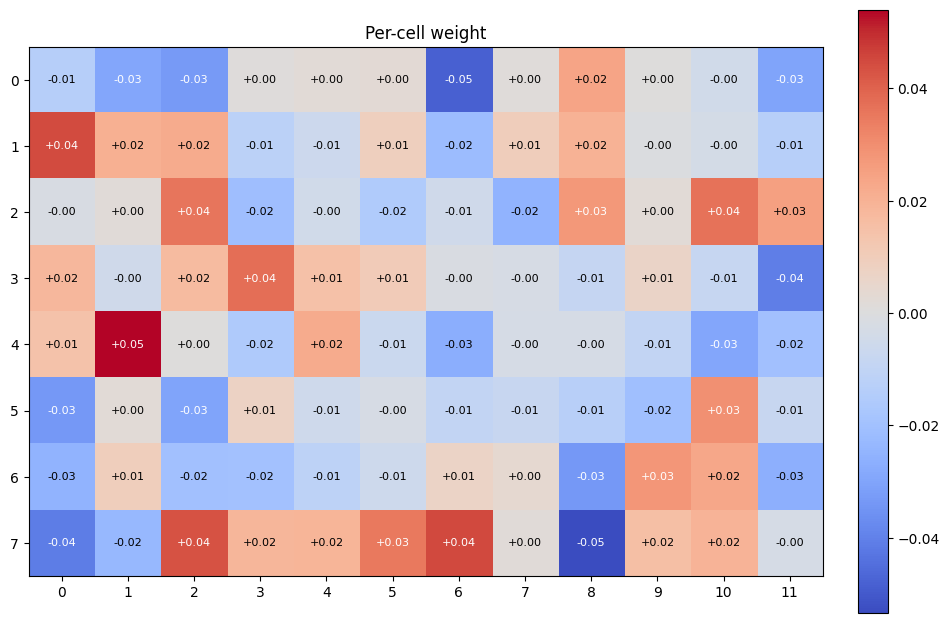

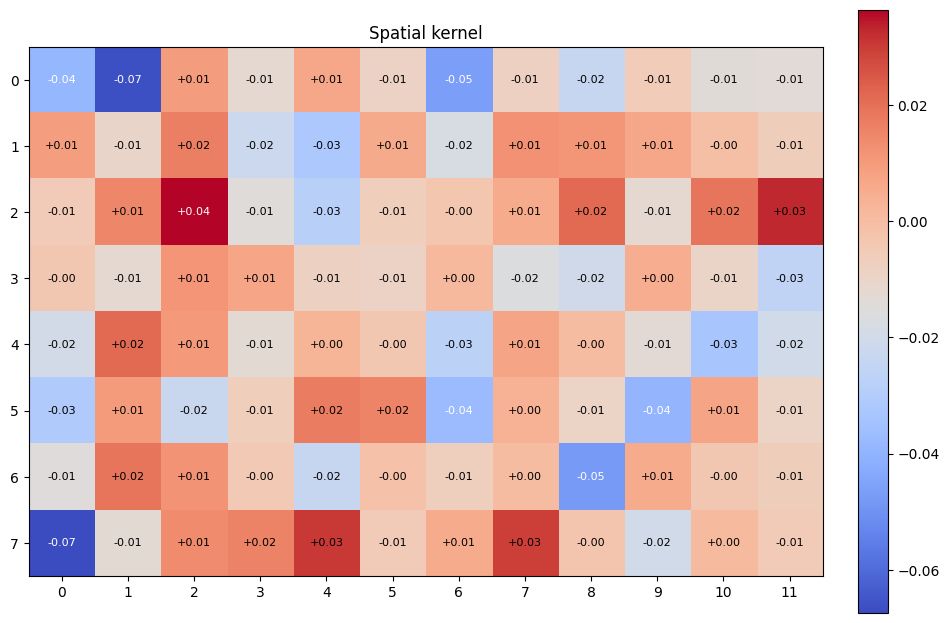

In [7]:
with torch.no_grad():
    # grab learned weights
    w1 = model.conv1.weight.squeeze()     # [8, 3]
    b1 = model.conv1.bias                 # [8]
    w2 = model.conv2.weight.squeeze(0)    # [8, GRID_H, GRID_W]
    b2 = model.conv2.bias.item()          # scalar

    # combine the two layers into a per-class, per-cell map
    # eff[c,h,w] = sum_k w2[k,h,w] * w1[k,c]
    eff = torch.einsum("khw,kc->chw", w2, w1)  # [3, GRID_H, GRID_W]

    # average across the three classes to get one number per cell
    threshold_grid = eff.mean(dim=0).cpu().numpy()
    show_weight_grid(threshold_grid, title="Per-cell weight")

    # the spatial kernel is just the mean of the w2 channels
    kernel_grid = w2.mean(dim=0).cpu().numpy()
    show_weight_grid(kernel_grid, title="Spatial kernel")


### 7. Evaluation

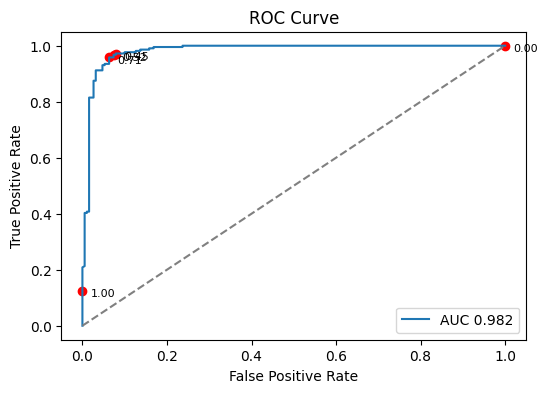

Best value near upper left corner!


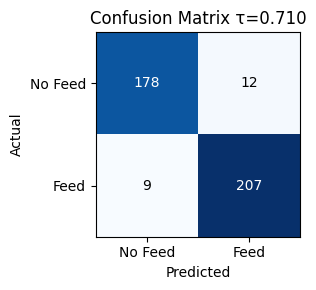

,Threshold,Accuracy,Precision,Recall,F1,Specificity,FPR
0,0.0000,0.532,0.532,1.000,0.695,0.000,1.000
1,0.5171,0.948,0.937,0.968,0.952,0.926,0.074
2,0.7097,0.948,0.945,0.958,0.952,0.937,0.063
3,0.4546,0.948,0.933,0.972,0.952,0.921,0.079
4,1.0000,0.534,1.000,0.125,0.222,1.000,0.000


False Positive Rate (FPR) - wrong feeding ratio   = FP / (FP + TN)
Specificity               - correct feeding ratio = TN / (TN + FP) = 1 − FPR


In [8]:
# Evaluate model

# 1. ROC CURVE
# Compute ROC curve and find best threshold
fpr, tpr, thresh = roc_curve(val_gt, val_preds)
roc_auc = auc(fpr, tpr)
best_idx = np.argmax(tpr - fpr)
best_th = thresh[best_idx]

# pick five thresholds: min, max, best, plus two next-best
valid = np.sort(np.unique(thresh[(thresh>0)&(thresh<1)]))
low, high = valid[0], valid[-1]
order = np.argsort(tpr - fpr)[::-1]
alts = [t for i,t in zip(order, thresh[order]) if t not in (low, high, best_th)][:2]
cands = [low, alts[0], best_th, alts[1], high]

# Plot ROC with markers
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='.5')
pts = [(fpr[np.where(thresh==t)[0][0]], tpr[np.where(thresh==t)[0][0]]) for t in cands]
xs, ys = zip(*pts)
plt.scatter(xs, ys, color='red')
for x,y,t in zip(xs, ys, cands):
    plt.text(x+0.02, y-0.02, f"{t:.2f}", fontsize=8)

plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.title("ROC Curve"); plt.show()

print("Best value near upper left corner!")

# 2. CONFUSION MATRIX
# Confusion matrix at best threshold
pred_best = (val_preds >= best_th).astype(int)
cm = confusion_matrix(val_gt, pred_best)
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap="Blues"); plt.title(f"Confusion Matrix τ={best_th:.3f}")
plt.xticks([0,1],["No Feed","Feed"]); plt.yticks([0,1],["No Feed","Feed"])
for i in (0,1):
    for j in (0,1):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

# 3. METRICS TABLE
# Build metrics table for each candidate threshold
rows = []
for t in cands:
    pred = (val_preds >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(val_gt, pred).ravel()
    rows.append({
        "Threshold": t,
        "Accuracy": accuracy_score(val_gt, pred),
        "Precision": precision_score(val_gt, pred, zero_division=0),
        "Recall": recall_score(val_gt, pred),
        "F1": f1_score(val_gt, pred, zero_division=0),
        "Specificity": tn/(tn+fp) if tn+fp else 0,
        "FPR": fp/(fp+tn) if fp+tn else 0
    })
df = pd.DataFrame(rows)

# highlight the best-threshold row in light green
def highlight_best(row):
    return ["background-color: darkgreen" if row.Threshold==best_th else "" for _ in row]

display(
    df.style
      .format({"Threshold":"{:.4f}","Accuracy":"{:.3f}","Precision":"{:.3f}", "Recall":"{:.3f}","F1":"{:.3f}","Specificity":"{:.3f}","FPR":"{:.3f}"})
      .apply(highlight_best, axis=1)
)

# Quick definitions
print("False Positive Rate (FPR) - wrong feeding ratio   = FP / (FP + TN)\n"
      "Specificity               - correct feeding ratio = TN / (TN + FP) = 1 − FPR")
